In [15]:
# import the necessary modules used throughout
from gerrychain import Graph
import gurobipy as gp
from gurobipy import GRB
import math

In [16]:
# import a file with Arkansas population data to a graph
file_path = '/spfda/datas/AR_county.json'
G = Graph.from_json(file_path)
print(G)

Graph with 75 nodes and 192 edges


In [17]:
# see the information contained in, for example, the first node in our graph
print(G.nodes[0])

{'boundary_node': False, 'area': 0.15957779913849965, 'STATEFP20': '05', 'COUNTYFP20': '047', 'COUNTYNS20': '00066853', 'GEOID20': '05047', 'NAME20': 'Franklin', 'NAMELSAD20': 'Franklin County', 'LSAD20': '06', 'CLASSFP20': 'H1', 'MTFCC20': 'G4020', 'CSAFP20': None, 'CBSAFP20': '22900', 'FUNCSTAT20': 'A', 'ALAND20': 1577206794, 'AWATER20': 28920052, 'INTPTLAT20': '+35.5085579', 'INTPTLON20': '-093.8876647', 'FILEID': 'PLST', 'STUSAB': 'AR', 'SUMLEV': '050', 'GEOVAR': '00', 'GEOCOMP': '00', 'CHARITER': '000', 'LOGRECNO': '0000025', 'GEOID': '0500000US05047', 'GEOCODE': '05047', 'REGION': '3', 'DIVISION': '7', 'STATE': '05', 'STATENS': '00068085', 'COUNTY': '047', 'COUNTYCC': 'H1', 'COUNTYNS': '00066853', 'CBSA': '22900', 'MEMI': '1', 'CSA': '999', 'METDIV': '99999', 'AREALAND': 1577206794, 'AREAWATR': 28920052, 'BASENAME': 'Franklin', 'NAME': 'Franklin County', 'FUNCSTAT': 'A', 'POP100': 17097, 'HU100': 7716, 'INTPTLAT': '+35.5085579', 'INTPTLON': '-093.8876647', 'LSADC': '06', 'P001000

In [18]:
# get total population from P0010001 to TOTPOP for all nodes
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    print(f"Name: {G.nodes[node]['NAME20']}, Population: {G.nodes[node]['TOTPOP']}")

Name: Franklin, Population: 17097
Name: Crawford, Population: 60133
Name: Jackson, Population: 16755
Name: Clay, Population: 14552
Name: Faulkner, Population: 123498
Name: Baxter, Population: 41627
Name: Little River, Population: 12026
Name: Boone, Population: 37373
Name: Ashley, Population: 19062
Name: Desha, Population: 11395
Name: St. Francis, Population: 23090
Name: Montgomery, Population: 8484
Name: Sharp, Population: 17271
Name: Greene, Population: 45736
Name: Woodruff, Population: 6269
Name: White, Population: 76822
Name: Lee, Population: 8600
Name: Conway, Population: 20715
Name: Howard, Population: 12785
Name: Nevada, Population: 8310
Name: Pulaski, Population: 399125
Name: Grant, Population: 17958
Name: Benton, Population: 284333
Name: Madison, Population: 16521
Name: Dallas, Population: 6482
Name: Cleveland, Population: 7550
Name: Crittenden, Population: 48163
Name: Lafayette, Population: 6308
Name: Saline, Population: 123416
Name: Chicot, Population: 10208
Name: Pope, Popul

In [19]:
# we want a 1% population deviation
deviation = 0.01

# 4 districts for Arkansas, find ideal population for each
k = 4
total_pop = sum(G.nodes[i]['TOTPOP'] for i in G.nodes)
ideal_pop = total_pop / k

# defining upper and lower bounds for our district populations
L = math.ceil((1 - deviation / 2) * ideal_pop)
U = math.floor((1 + deviation / 2) * ideal_pop)
print(f'Lower Bound L = {L}\nUpper Bound U = {U}\nNumber of Districts k = {k}')

Lower Bound L = 749117
Upper Bound U = 756645
Number of Districts k = 4


In [20]:
# create our gurobi model
m = gp.Model()

# add variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)  # x[i,j] = 1 if i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] = 1 when edge {u,v} is cut

In [21]:
# SET OBJECTIVE - to minimize cut edges
m.setObjective(gp.quicksum(y[u,v] for u,v in G.edges), GRB.MINIMIZE)

In [22]:
# ADD CONSTRAINTS
# each county i must be assigned to exactly one district
m.addConstrs(gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# each district has a population of at least L and at most U
m.addConstrs(gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k))
m.addConstrs(gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k))

# edge {u,v} is said to be cut if u is assigned to district j but v is not.
m.addConstrs(x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [23]:
# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
import networkx as nx
DG = nx.DiGraph(G)      # directed version of G
f = m.addVars(DG.edges)

In [24]:
# implement the big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# each district j must have one root
m.addConstrs(gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# node i must be assigned to district j to serve as its root
m.addConstrs(r[i,j] <= x[i,j] for i in G.nodes for j in range(k)) 

# if not a root, consume some flow
# if a root, only send out (so much) flow
m.addConstrs(gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i)) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes)

# flow can't be sent across cut edges
m.addConstrs(f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges)

m.update()

In [25]:
# solve our generated IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10885H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1422 rows, 1176 columns and 5748 nonzeros
Model fingerprint: 0xa1a4a853
Variable types: 384 continuous, 792 integer (792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.02s
Presolved: 1422 rows, 1176 columns, 5748 nonzeros
Variable types: 384 continuous, 792 integer (792 binary)

Root relaxation: objective 0.000000e+00, 581 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  316          -    0.00000      -     -    0s
     0     0    1.1061

In [26]:
# print objective value - the number of cut edegs
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [[i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [[G.nodes[i]["NAME20"] for i in districts[j]] for j in range(k)]
district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 33.0
District 0 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 1 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Newton', 'Cross']

District 2 has population 750788 and contains counties ['Faulkner', 'Conway', 'Pulaski', 'Saline', 'Lonoke', 'Perry']

District 3 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'Lincoln', 'Sco

In [27]:
# VISUALIZE SOLUTION ON A MAP
import geopandas as gpd

# Read and compile Arkansas county shapefile
filepath = '/spfda/datas/AR_county.shp'
df = gpd.read_file(filepath)

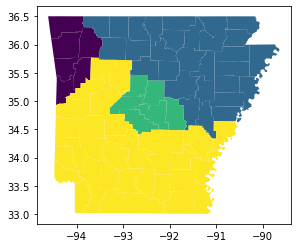

In [28]:
# Which district is each county assigned to?
assignment = [-1 for i in G.nodes]
labeling = {i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5}

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = {G.nodes[i]['GEOID20'] : i for i in G.nodes}

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()